# Model Evaluation and Visualization Notebook

This notebook loads a pre-trained U-Net model, evaluates its performance on the test dataset, and visualizes its predictions.

## Step 1: Setup and Configuration
Import necessary libraries and define the configuration parameters. These must match the parameters used during training.

In [ ]:
import os
import math
import random
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from skimage import io as skio
from patchify import patchify
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import normalize, to_categorical

# Set the framework for segmentation-models
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

CONFIG = {
    'PATCH_SIZE': 256,
    'THRESHOLD': 0.03,
    'BACKBONE': 'resnet101',
    'DATA_PATH': './data/CoFly-WeedDB',
    'MODEL_PATH': './models/unet_resnet101_best_model.keras',
    'OUTPUT_DIR': './output/'
}

## Step 2: Data Preparation for the Test Set
We define the necessary classes and functions to load and preprocess the test data. This process must perfectly replicate the preprocessing applied during training to ensure the model receives data in the expected format.

In [ ]:
class Patches:
    def __init__(self, im_list, msk_list, patch_size, threshold=0.03):
        self.im_list = im_list
        self.msk_list = msk_list
        self.PATCH_SIZE = patch_size
        self.threshold = threshold

    def image_to_patches(self, image):
        slc_size = self.PATCH_SIZE
        # For masks (2D) and images (3D)
        if len(image.shape) == 3:
            h, w, c = image.shape
            pad_h = (slc_size - h % slc_size) % slc_size
            pad_w = (slc_size - w % slc_size) % slc_size
            padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            patch_shape = (slc_size, slc_size, c)
        else:
            h, w = image.shape
            pad_h = (slc_size - h % slc_size) % slc_size
            pad_w = (slc_size - w % slc_size) % slc_size
            padded_image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')
            patch_shape = (slc_size, slc_size)

        patches = patchify(padded_image, patch_shape, step=slc_size)
        return patches

    def load_image(self, path):
        return skio.imread(path)

    def patchify_and_filter(self):
        imgs, anns = [], []
        AREA = self.PATCH_SIZE * self.PATCH_SIZE
        f_AREA = int(self.threshold * AREA)
        
        print(f"Filtering patches with more than {f_AREA} weed pixels.")

        iterator = tqdm.tqdm(zip(self.im_list, self.msk_list), total=len(self.im_list), desc="Patchifying test set")
        for im_path, msk_path in iterator:
            image = self.load_image(im_path)
            mask = self.load_image(msk_path)
            if len(mask.shape) > 2: mask = mask[:,:,0] # Ensure mask is 2D

            image_patches = self.image_to_patches(image)
            mask_patches = self.image_to_patches(mask)

            for i in range(image_patches.shape[0]):
                for j in range(image_patches.shape[1]):
                    patch = image_patches[i, j, 0, :, :, :]
                    mask_patch = mask_patches[i, j, :, :]
                    if mask_patch.sum() > f_AREA:
                        imgs.append(patch)
                        anns.append(mask_patch)
        
        return np.array(imgs), np.array(anns)


def prepare_test_data(config):
    print('Preparing Test Dataset...')
    
    #   1. Get File Paths (Correct)  
    test_split_file = os.path.join(config['DATA_PATH'], 'test_split1.txt')
    with open(test_split_file, 'r') as f:
        test_ids = [line.strip() for line in f]

    img_paths = [os.path.join(config['DATA_PATH'], 'images', itm) for itm in test_ids]
    msk_paths = [os.path.join(config['DATA_PATH'], 'labels_1d', itm) for itm in test_ids]

    #   2. Create and Filter Patches (Correct)  
    patch_generator = Patches(img_paths, msk_paths, config['PATCH_SIZE'], config['THRESHOLD'])
    X_test, Y_test = patch_generator.patchify_and_filter()
    print(f'\nShape after Patching: X_test={X_test.shape}, Y_test={Y_test.shape}')

    #  3. Normalize the Images (THE FIX IS HERE) 
    X_test_normalized = normalize(X_test, axis=1)

    #  4. Label Encode Masks (Correct) 
    labelencoder = LabelEncoder()
    n, h, w = Y_test.shape
    masks_reshaped = Y_test.reshape(-1, 1)
    masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
    Y_test_encoded = masks_reshaped_encoded.reshape(n, h, w)
    n_classes = len(np.unique(Y_test_encoded))
    print(f"Total Classes Detected: {n_classes}")

    #  5. Apply Backbone-Specific Preprocessing (Correct) 
    preprocess_input = sm.get_preprocessing(config['BACKBONE'])
    X_test_preprocessed = preprocess_input(X_test_normalized.astype('float32'))

    #  6. Prepare Masks for Model Evaluation (Correct) 
    Y_test_int = np.expand_dims(Y_test_encoded, axis=3)
    Y_test_cat = to_categorical(Y_test_int, num_classes=n_classes)
    
    print("\n TEST DATASET PREPARATION COMPLETE ")
    return X_test, X_test_preprocessed, Y_test_int, Y_test_cat, n_classes

X_test_orig, X_test_prep, Y_test_int, Y_test_cat, N_CLASSES = prepare_test_data(CONFIG)

Preparing Test Dataset...
Filtering patches with more than 1966 weed pixels.


Patchifying test set: 100%|██████████| 67/67 [00:01<00:00, 46.82it/s]



Shape after Patching: X_test=(276, 256, 256, 3), Y_test=(276, 256, 256)


/Users/sagnikbarik/.pyenv/versions/weedsegmentation/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total Classes Detected: 4

--- TEST DATASET PREPARATION COMPLETE ---


## Step 3: Load the Trained Model

We first need to build the model architecture so that we can then load the saved weights into it.

In [ ]:
def build_unet_resnet101(input_shape, n_classes, backbone='resnet101'):
    """Builds a U-Net model, ensuring architecture matches training."""
    model = sm.Unet(
        backbone_name=backbone,
        input_shape=input_shape,
        classes=n_classes,
        activation='softmax',
        # The loaded weights will overwrite these.
        encoder_weights='imagenet' 
    )
    return model

#   When you build and load the model  
input_shape = (CONFIG['PATCH_SIZE'], CONFIG['PATCH_SIZE'], 3)
# Build the model correctly
model = build_unet_resnet101(input_shape, N_CLASSES, CONFIG['BACKBONE'])

# Load your trained weights (this part is correct)
model.load_weights(CONFIG['MODEL_PATH'])
print("\nModel built and weights loaded successfully.")


Model built and weights loaded successfully.


## Step 4: Evaluate Model Performance

Now we evaluate the model on the preprocessed test data to get quantitative metrics like Loss, IoU, and F1-Score.

In [ ]:
# The model must be compiled before evaluation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print("\n  Evaluating model on the test set  ")
results = model.evaluate(X_test_prep, Y_test_cat, batch_size=8)

print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test IoU Score: {results[1]:.4f}")
print(f"Test F1-Score: {results[2]:.4f}")


--- Evaluating model on the test set ---
35/35 [==============================] - 21s 565ms/step - loss: 0.5535 - iou_score: 0.6494 - f1-score: 0.7253

Test Loss: 0.5535
Test IoU Score: 0.6494
Test F1-Score: 0.7253


## Step 5: Generate Detailed Classification Report and Mean IoU

We will now get predictions for the entire test set to compute a detailed classification report (precision, recall, f1-score for each class) and the primary segmentation metric, Mean Intersection over Union (mIoU).

In [ ]:
print("\n  Generating Predictions for Detailed Report  ")
y_pred = model.predict(X_test_prep, batch_size=8)
y_pred_argmax = np.argmax(y_pred, axis=3)

# We need to flatten the arrays to compare them
y_test_flat = Y_test_int.flatten()
y_pred_flat = y_pred_argmax.flatten()

# Define class names (assuming 0: background, 1-3: weed types)
class_names = ['Background', 'Weed Type 1', 'Weed Type 2', 'Weed Type 3']

print("\n  Classification Report  ")
print(classification_report(y_test_flat, y_pred_flat, target_names=class_names))

# Calculate and Display Class-wise and Mean IoU 
print("\n--- IoU Scores for Each Class ---")
iou_metric = tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)
iou_metric.update_state(Y_test_int, y_pred_argmax)

confusion_matrix = iou_metric.total_cm.numpy()

for i in range(N_CLASSES):
    true_positives = confusion_matrix[i, i]
    false_positives = np.sum(confusion_matrix[:, i]) - true_positives
    false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
    
    denominator = true_positives + false_positives + false_negatives
    iou = true_positives / (denominator + 1e-6) # Add epsilon to avoid division by zero
    print(f"Class '{class_names[i]}': IoU = {iou:.4f}")

mean_iou = iou_metric.result().numpy()
print(f"\nMean Intersection over Union (mIoU): {mean_iou:.4f}")


--- Generating Predictions for Detailed Report ---
35/35 [==============================] - 20s 564ms/step

--- Classification Report ---
              precision    recall  f1-score   support

  Background       0.96      0.89      0.92  14878691
 Weed Type 1       0.75      0.87      0.81    689340
 Weed Type 2       0.16      0.98      0.28     25262
 Weed Type 3       0.59      0.77      0.67   2494643

    accuracy                           0.88  18087936
   macro avg       0.62      0.88      0.67  18087936
weighted avg       0.90      0.88      0.88  18087936


--- IoU Scores for Each Class ---
Class 'Background': IoU = 0.8593
Class 'Weed Type 1': IoU = 0.6777
Class 'Weed Type 2': IoU = 0.1632
Class 'Weed Type 3': IoU = 0.5007

Mean Intersection over Union (mIoU): 0.5502


## Step 6: Visual Inference on Test Images

Finally, let's look at some actual predictions. We'll pick a few random images from our test set and compare the original image, the ground truth mask, and the segmentation mask predicted by our trained model.


--- Generating Visual Inference on Test Images ---


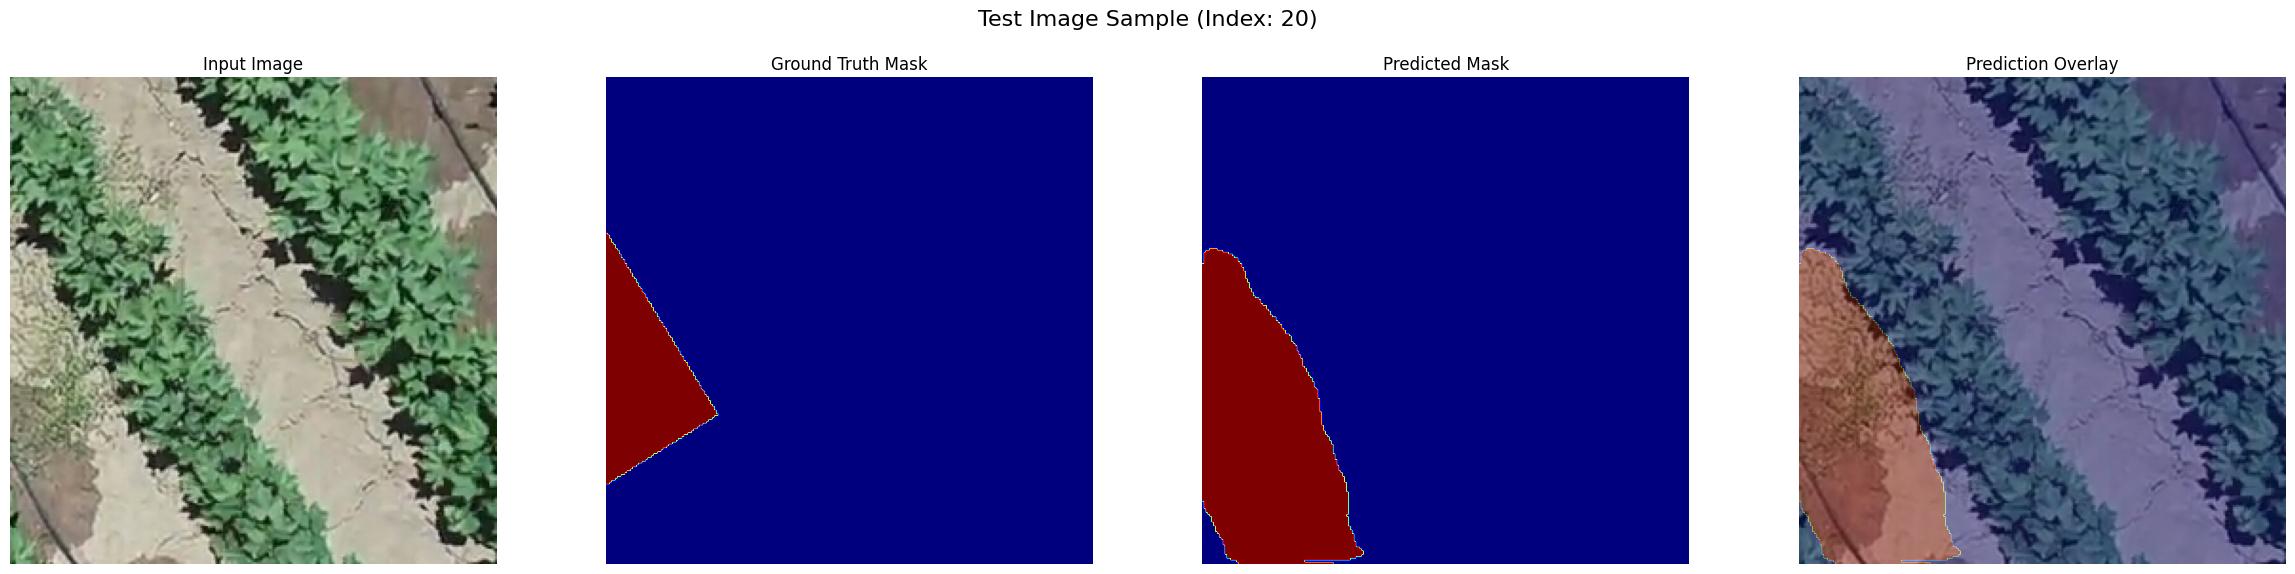

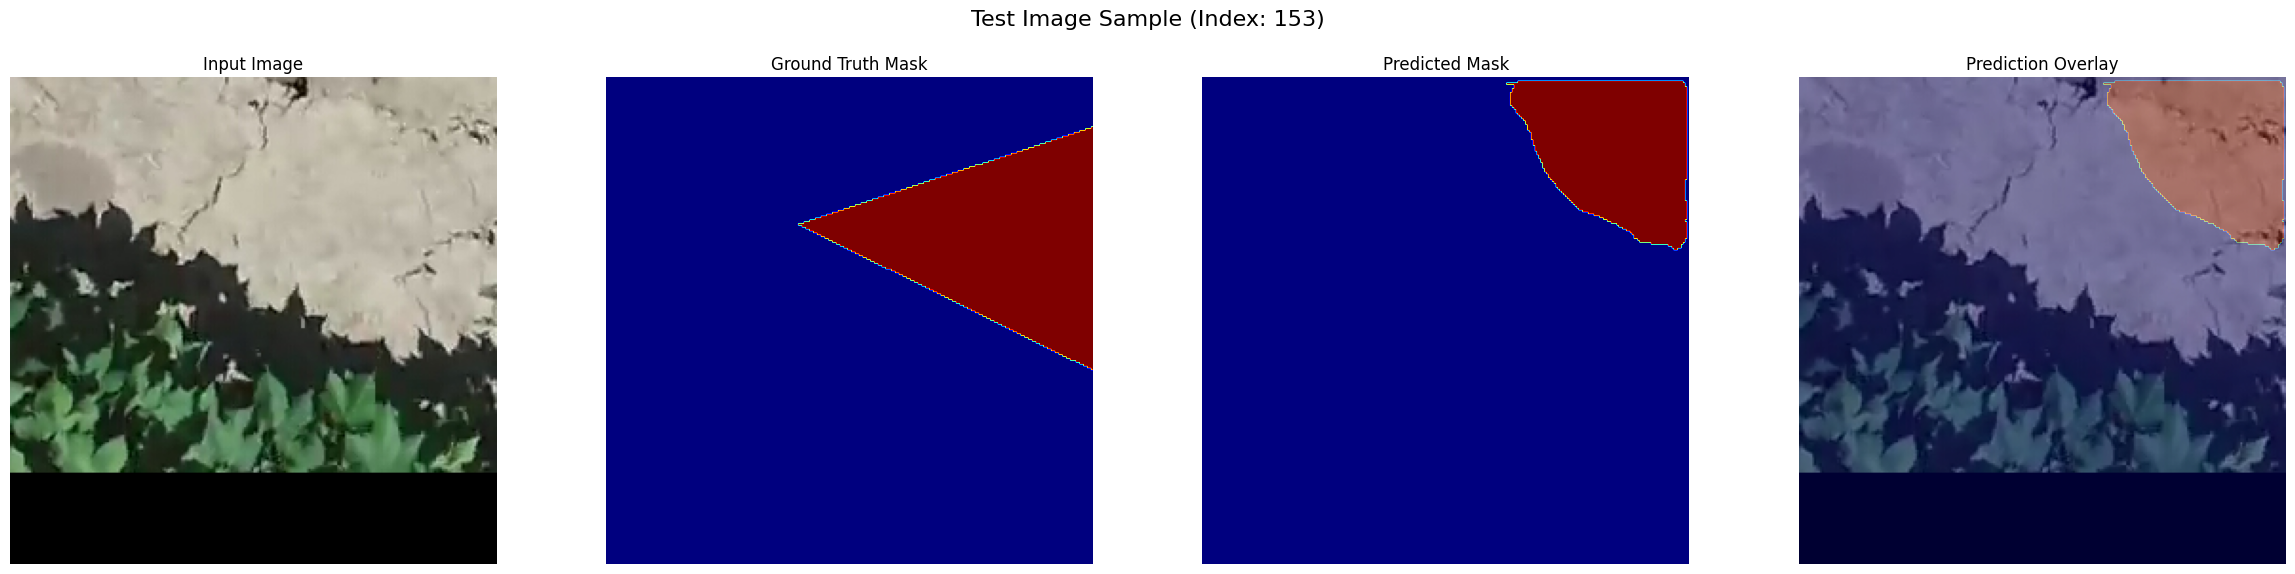

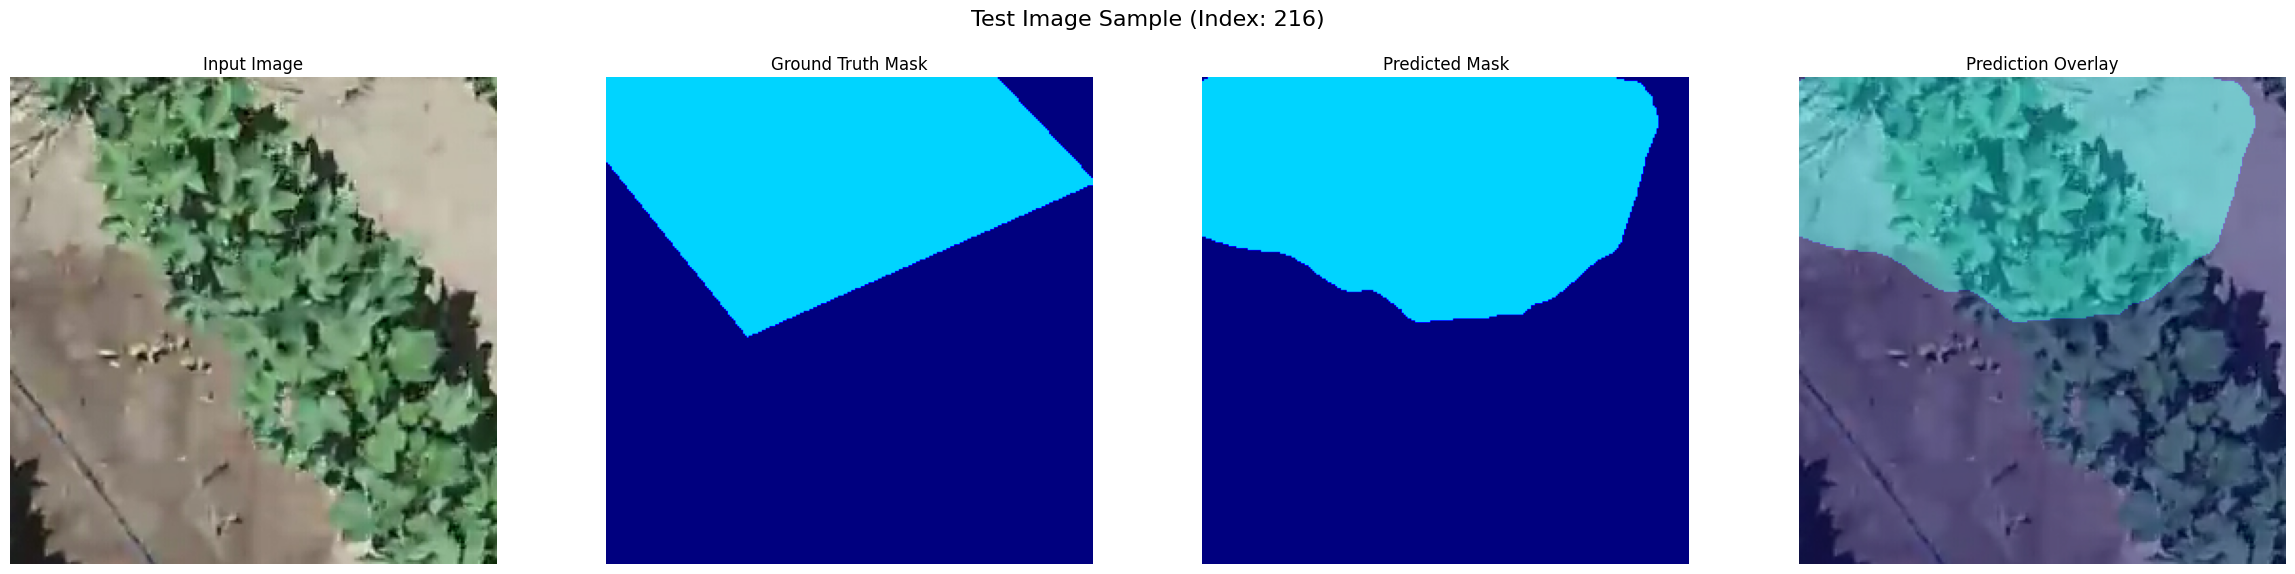

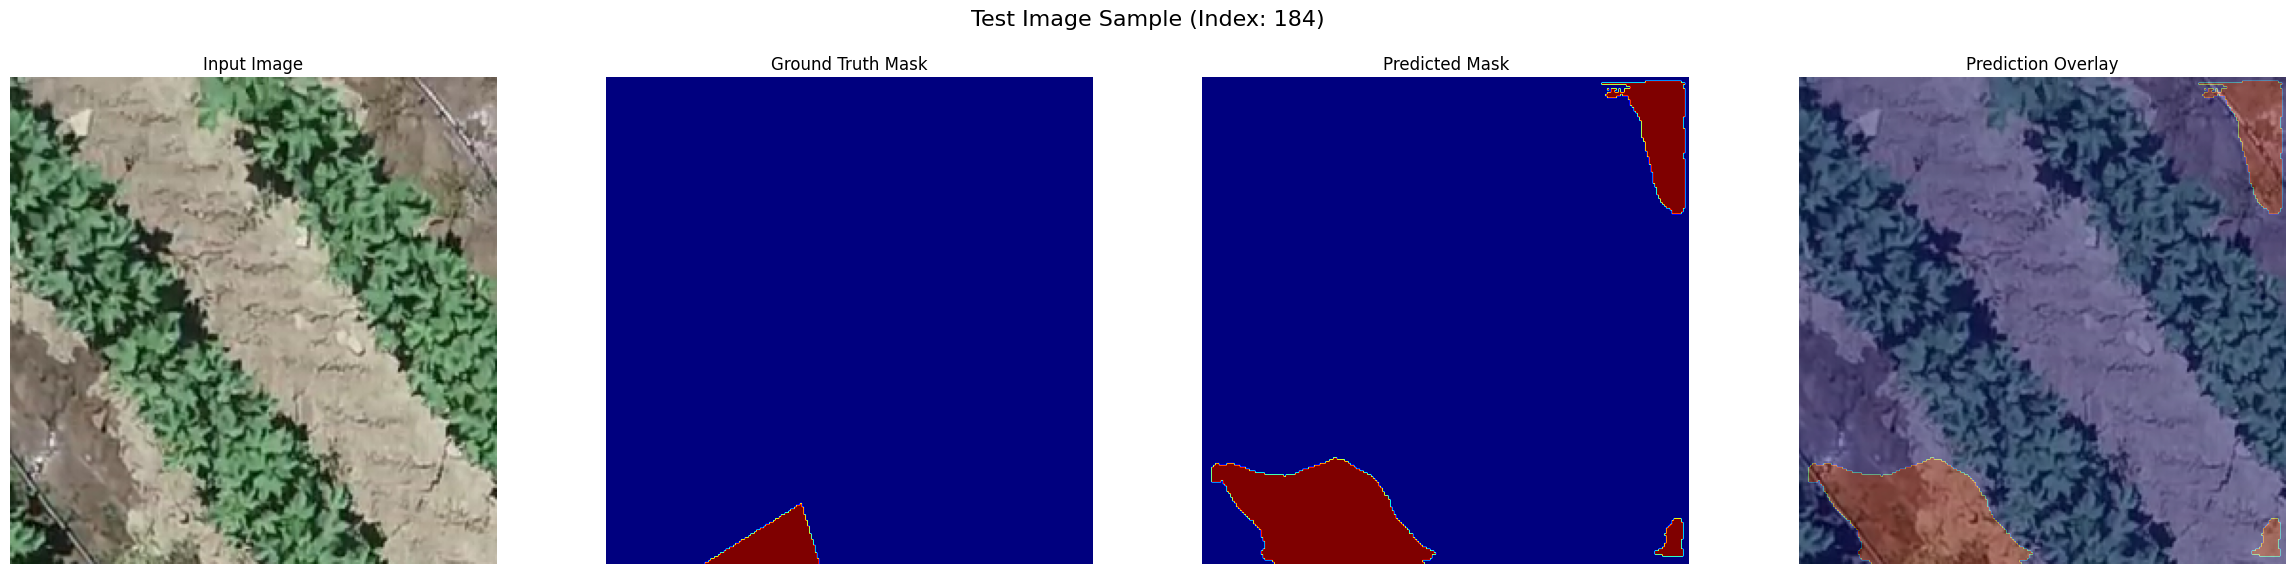

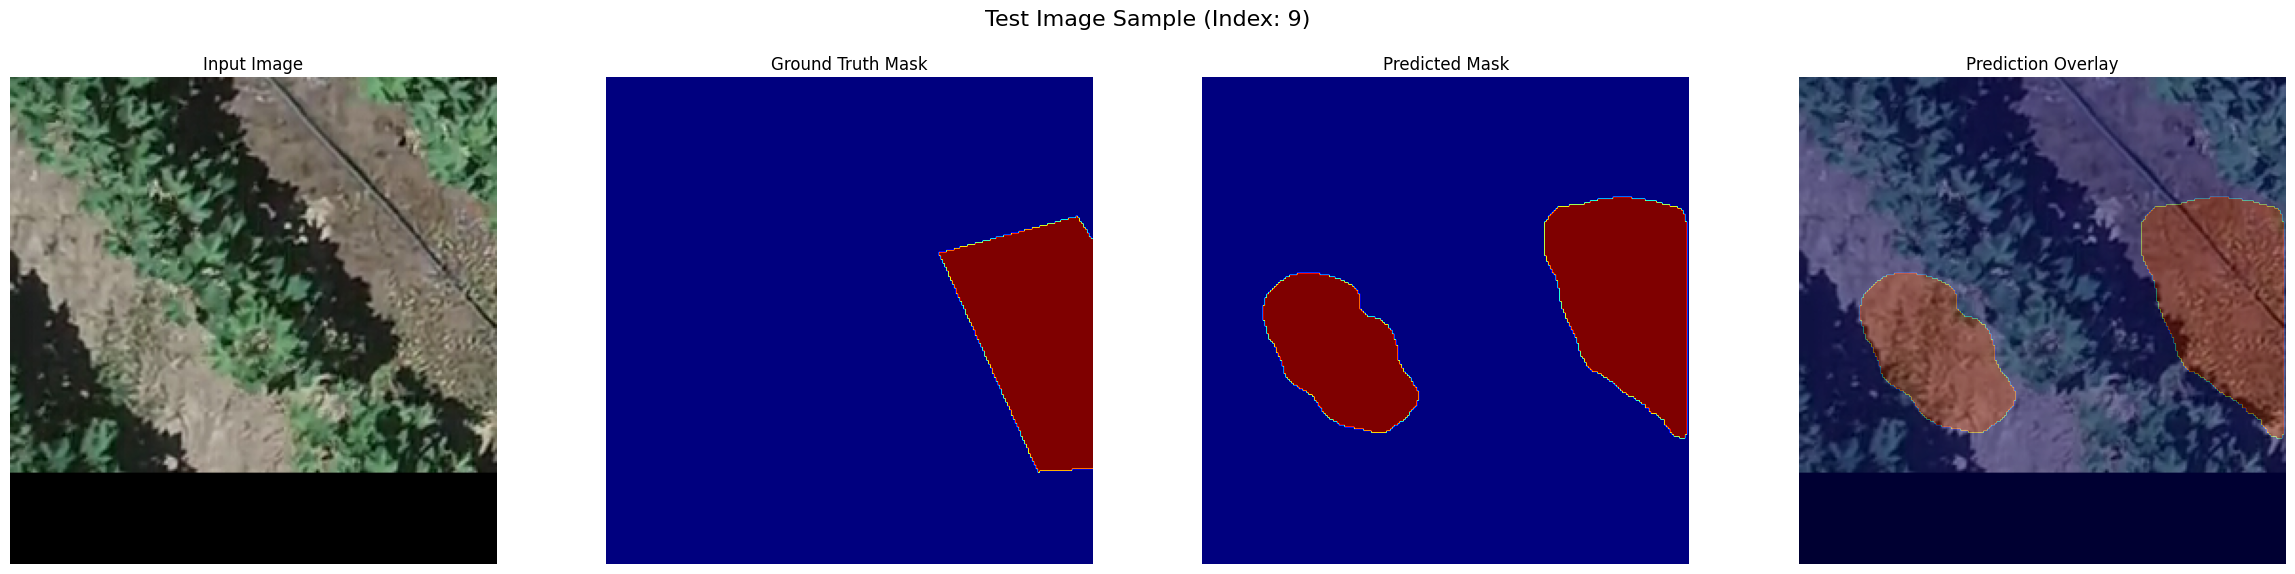

In [ ]:
print("\n--- Generating Visual Inference on Test Images ---")
num_images_to_show = 5
test_indices = random.sample(range(len(X_test_orig)), num_images_to_show)

for i, index in enumerate(test_indices):
    test_img_display = X_test_orig[index]
    
    # Get the ground truth and predicted masks
    ground_truth = Y_test_int[index].squeeze()
    predicted_img = y_pred_argmax[index]
    
    plt.figure(figsize=(24, 6)) # Make the figure wider
    plt.suptitle(f'Test Image Sample (Index: {index})', fontsize=16)

    # Plot 1: Input Image
    plt.subplot(1, 4, 1)
    plt.title('Input Image')
    plt.imshow(test_img_display)
    plt.axis('off')

    # Plot 2: Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(ground_truth, cmap='jet', vmin=0, vmax=N_CLASSES-1)
    plt.axis('off')

    # Plot 3: Predicted Mask
    plt.subplot(1, 4, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_img, cmap='jet', vmin=0, vmax=N_CLASSES-1)
    plt.axis('off')

    # Plot 4: Prediction Overlay
    plt.subplot(1, 4, 4)
    plt.title('Prediction Overlay')
    plt.imshow(test_img_display) # Show the original image
    # Overlay the predicted mask with transparency
    plt.imshow(predicted_img, cmap='jet', alpha=0.4, vmin=0, vmax=N_CLASSES-1)
    plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

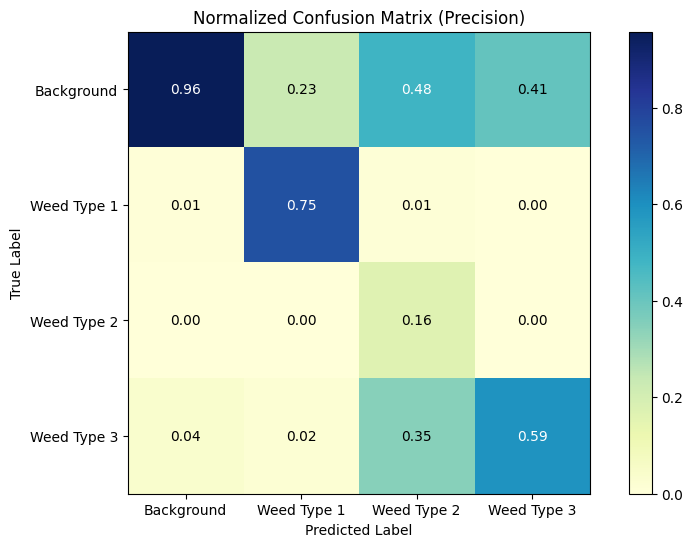

In [ ]:
# Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)

# 2. Normalize by column to get PRECISION 
col_sums = conf_matrix.sum(axis=0)
conf_matrix_precision = np.zeros_like(conf_matrix, dtype=float)
non_zero_cols = np.where(col_sums > 0)[0]
if non_zero_cols.size > 0:
    conf_matrix_precision[:, non_zero_cols] = conf_matrix[:, non_zero_cols].astype('float') / col_sums[non_zero_cols]


# 3. Visualize the Precision Matrix 
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(conf_matrix_precision, interpolation='nearest', cmap=plt.cm.YlGnBu)

# Add a color bar
ax.figure.colorbar(im, ax=ax)

# Set the labels and title
ax.set(xticks=np.arange(conf_matrix_precision.shape[1]),
    yticks=np.arange(conf_matrix_precision.shape[0]),
    xticklabels=class_names, yticklabels=class_names,
    title='Normalized Confusion Matrix (Precision)',
    ylabel='True Label',
    xlabel='Predicted Label')

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), ha="center", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = conf_matrix_precision.max() / 2.
for i in range(conf_matrix_precision.shape[0]):
    for j in range(conf_matrix_precision.shape[1]):
        ax.text(j, i, format(conf_matrix_precision[i, j], '.2f'),
                ha="center", va="center",
                color="black" if conf_matrix_precision[i, j] < thresh else "white")

plt.show()